# Customer Churn Prediction - Model Building and Evaluation

## Objective

This notebook builds and evaluates machine learning models to predict customer churn. We compare multiple algorithms and select the best model based on business value optimization.

## Business Goal

**Primary Metric:** Maximize recall (catch as many churners as possible)

**Why Recall Matters:**
- Missing a churner costs $2,000 in lost lifetime value
- False alarm costs $100 in wasted retention offer
- Missing churners is 20x more expensive than false alarms
- Therefore, we prioritize catching churners over precision

**Success Criteria:**
- Recall above 75%
- ROC AUC above 0.80
- Positive net business value

## Modeling Approach

This notebook follows a systematic modeling process:

### 1. Data Preparation
- Load engineered features
- Encode categorical variables
- Split into training and test sets (80/20)
- Scale features for algorithms that require it
- Validate data quality

### 2. Baseline Model - Logistic Regression
- Train simple interpretable model
- Establish performance baseline
- Identify most important features
- Set benchmark to beat

### 3. Advanced Models
- Random Forest (ensemble of decision trees)
- XGBoost (gradient boosted trees)
- Compare against baseline

### 4. Model Evaluation
- Calculate standard metrics (accuracy, precision, recall, F1, ROC AUC)
- Generate confusion matrices
- Plot ROC curves
- Analyze feature importance
- Calculate business impact

### 5. Model Selection
- Compare all models on business value
- Select model with best net benefit
- Document deployment recommendations

## Models Tested

**Logistic Regression**
- Interpretable linear model
- Fast training and prediction
- Works well with engineered features
- Baseline model

**Random Forest**
- Ensemble of 100 decision trees
- Handles non-linear relationships
- Robust to outliers
- Automatic feature interaction detection

**XGBoost**
- Gradient boosted decision trees
- State-of-the-art algorithm
- Excellent performance on tabular data
- Handles class imbalance well

## Evaluation Metrics

**Accuracy:** Percentage of correct predictions overall

**Precision:** Of predicted churners, what percentage actually churned

**Recall:** Of actual churners, what percentage did we catch (MOST IMPORTANT)

**F1 Score:** Harmonic mean of precision and recall

**ROC AUC:** Area under receiver operating characteristic curve (model discrimination ability)

**Business Metrics:**
- Revenue saved (true positives x $2,000)
- Revenue lost (false negatives x $2,000)
- Wasted spend (false positives x $100)
- Net benefit (revenue saved - revenue lost - wasted spend)

## Expected Outcome

We expect to achieve:
- 75-85% recall (catching most churners)
- 0.82-0.85 ROC AUC (strong discrimination)
- $500K+ net business value on test set
- Scalable deployment recommendation

---

In [7]:
"""
CUSTOMER CHURN PREDICTION - MODEL BUILDING
===========================================
Goal: Build predictive models to identify customers at risk of churning
Author: [Your Name]
Date: January 2026
"""

# ============================================================================
# IMPORTS
# ============================================================================
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import (
    confusion_matrix, classification_report, roc_curve, 
    roc_auc_score, precision_recall_curve, f1_score
)
from imblearn.over_sampling import SMOTE
import warnings
warnings.filterwarnings('ignore')

# Set random seed for reproducibility
RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)

# Set visualization style
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

print("✅ All libraries imported successfully")

# ============================================================================
# LOAD ENGINEERED DATA
# ============================================================================
print("="*80)
print("LOADING ENGINEERED DATASET")
print("="*80)

df = pd.read_csv('C:/Users/nikhi/OneDrive/Desktop/Python/Data Analysis Projects/telco_churn_engineered.csv')

print(f"\nDataset shape: {df.shape}")
print(f"Features: {len(df.columns)}")
print(f"Target variable: Churn")

# Quick check
print("\nChurn distribution:")
print(df['Churn'].value_counts())
print(f"\nChurn rate: {(df['Churn'] == 'Yes').mean() * 100:.1f}%")

# Show first few rows
print("\nSample of data:")
print(df.head())

print("\n✅ Data loaded successfully - ready for modeling!")

✅ All libraries imported successfully
LOADING ENGINEERED DATASET

Dataset shape: (7032, 29)
Features: 29
Target variable: Churn

Churn distribution:
Churn
No     5163
Yes    1869
Name: count, dtype: int64

Churn rate: 26.6%

Sample of data:
   customerID  gender  SeniorCitizen Partner Dependents  tenure PhoneService  \
0  7590-VHVEG  Female              0     Yes         No       1           No   
1  5575-GNVDE    Male              0      No         No      34          Yes   
2  3668-QPYBK    Male              0      No         No       2          Yes   
3  7795-CFOCW    Male              0      No         No      45           No   
4  9237-HQITU  Female              0      No         No       2          Yes   

      MultipleLines InternetService OnlineSecurity  ... TotalCharges Churn  \
0  No phone service             DSL             No  ...        29.85    No   
1                No             DSL            Yes  ...      1889.50    No   
2                No             DSL         

In [9]:
# ============================================================================
# SECTION 1: DATA PREPARATION
# ============================================================================
print("\n" + "="*80)
print("DATA PREPARATION FOR MODELING")
print("="*80)

# ----------------------------------------------------------------------------
# 1.1: SELECT FEATURES FOR MODELING
# ----------------------------------------------------------------------------
print("\n1. FEATURE SELECTION")
print("-" * 60)

# Features we'll use (based on our analysis)
features_to_use = [
    # Original features (high correlation)
    'tenure',
    'MonthlyCharges',
    'Contract',
    'InternetService',
    'OnlineSecurity',
    'OnlineBackup',
    'TechSupport',
    'PaymentMethod',
    'PaperlessBilling',
    
    # Engineered features (our best predictors)
    'ContractRiskScore',
    'ServiceAdoptionRate',
    'HasFiberOptic',
    'AvgRevenuePerService',
    'TenureBucket',
    'ChargeCategory',
    
    # Demographics (showed impact)
    'SeniorCitizen',
    'Partner',
    'Dependents'
]

# Target variable
target = 'Churn'

print(f"Selected {len(features_to_use)} features for modeling:")
for i, feat in enumerate(features_to_use, 1):
    print(f"  {i:2d}. {feat}")

print(f"\nTarget variable: {target}")

# Create modeling dataset
X = df[features_to_use].copy()
y = df[target].copy()

print(f"\nX shape: {X.shape}")
print(f"y shape: {y.shape}")

# ----------------------------------------------------------------------------
# 1.2: IDENTIFY CATEGORICAL VS NUMERIC FEATURES
# ----------------------------------------------------------------------------
print("\n2. FEATURE TYPES")
print("-" * 60)

# Categorical features that need encoding
categorical_features = [
    'Contract', 'InternetService', 'OnlineSecurity', 'OnlineBackup',
    'TechSupport', 'PaymentMethod', 'PaperlessBilling', 'TenureBucket',
    'ChargeCategory', 'Partner', 'Dependents'
]

# Numeric features (already numbers)
numeric_features = [
    'tenure', 'MonthlyCharges', 'ContractRiskScore', 'ServiceAdoptionRate',
    'HasFiberOptic', 'AvgRevenuePerService', 'SeniorCitizen'
]

print(f"Categorical features ({len(categorical_features)}):")
print(f"  {categorical_features}")

print(f"\nNumeric features ({len(numeric_features)}):")
print(f"  {numeric_features}")

# ----------------------------------------------------------------------------
# 1.3: ENCODE CATEGORICAL VARIABLES
# ----------------------------------------------------------------------------
print("\n3. ENCODING CATEGORICAL VARIABLES")
print("-" * 60)

# We'll use Label Encoding for binary, One-Hot for multi-class
X_encoded = X.copy()

# Binary categorical variables (Yes/No) - use Label Encoding
binary_cols = ['OnlineSecurity', 'OnlineBackup', 'TechSupport', 
               'PaperlessBilling', 'Partner', 'Dependents']

from sklearn.preprocessing import LabelEncoder

for col in binary_cols:
    if col in X_encoded.columns:
        le = LabelEncoder()
        X_encoded[col] = le.fit_transform(X_encoded[col])
        print(f"  ✓ Encoded {col}: {X[col].unique()[:3]} → {X_encoded[col].unique()[:3]}")

# Multi-class categorical variables - use One-Hot Encoding
multi_class_cols = ['Contract', 'InternetService', 'PaymentMethod', 
                    'TenureBucket', 'ChargeCategory']

print("\n  Creating dummy variables for multi-class features...")
X_encoded = pd.get_dummies(X_encoded, columns=multi_class_cols, drop_first=True)

print(f"\n  Original features: {X.shape[1]}")
print(f"  After encoding: {X_encoded.shape[1]}")
print(f"  Added {X_encoded.shape[1] - X.shape[1]} dummy variables")

# Encode target variable (Churn: No=0, Yes=1)
y_encoded = (y == 'Yes').astype(int)

print(f"\n  Target encoding:")
print(f"    'No' → 0 ({(y_encoded == 0).sum():,} samples)")
print(f"    'Yes' → 1 ({(y_encoded == 1).sum():,} samples)")

# ----------------------------------------------------------------------------
# 1.4: TRAIN/TEST SPLIT (STRATIFIED)
# ----------------------------------------------------------------------------
print("\n4. TRAIN/TEST SPLIT")
print("-" * 60)

# Use stratified split to maintain churn ratio in both sets
X_train, X_test, y_train, y_test = train_test_split(
    X_encoded, 
    y_encoded,
    test_size=0.2,        # 80/20 split
    random_state=RANDOM_STATE,
    stratify=y_encoded    # Keep same churn ratio in train/test
)

print(f"Total samples: {len(X_encoded):,}")
print(f"  Training set: {len(X_train):,} ({len(X_train)/len(X_encoded)*100:.1f}%)")
print(f"  Test set: {len(X_test):,} ({len(X_test)/len(X_encoded)*100:.1f}%)")

print(f"\nChurn distribution in training set:")
print(f"  No churn (0): {(y_train == 0).sum():,} ({(y_train == 0).mean()*100:.1f}%)")
print(f"  Churn (1): {(y_train == 1).sum():,} ({(y_train == 1).mean()*100:.1f}%)")

print(f"\nChurn distribution in test set:")
print(f"  No churn (0): {(y_test == 0).sum():,} ({(y_test == 0).mean()*100:.1f}%)")
print(f"  Churn (1): {(y_test == 1).sum():,} ({(y_test == 1).mean()*100:.1f}%)")

print("\n✓ Stratification successful - same proportions in train/test")

# ----------------------------------------------------------------------------
# 1.5: FEATURE SCALING (For Logistic Regression)
# ----------------------------------------------------------------------------
print("\n5. FEATURE SCALING")
print("-" * 60)

# Only scale numeric features (tree models don't need scaling)
# We'll create both scaled and unscaled versions

from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()

# Fit on training data only (prevent data leakage)
X_train_scaled = X_train.copy()
X_test_scaled = X_test.copy()

# Scale only numeric columns
numeric_cols_in_X = [col for col in X_train.columns if any(feat in col for feat in numeric_features)]

X_train_scaled[numeric_cols_in_X] = scaler.fit_transform(X_train[numeric_cols_in_X])
X_test_scaled[numeric_cols_in_X] = scaler.transform(X_test[numeric_cols_in_X])

print(f"Scaled {len(numeric_cols_in_X)} numeric features:")
print(f"  {numeric_cols_in_X[:5]}...")  # Show first 5

print("\nExample - before and after scaling (tenure):")
if 'tenure' in X_train.columns:
    print(f"  Before: mean={X_train['tenure'].mean():.2f}, std={X_train['tenure'].std():.2f}")
    print(f"  After:  mean={X_train_scaled['tenure'].mean():.2f}, std={X_train_scaled['tenure'].std():.2f}")

print("\n💡 NOTE:")
print("   - Scaled data: Use for Logistic Regression")
print("   - Unscaled data: Use for Random Forest, XGBoost")

# ----------------------------------------------------------------------------
# SUMMARY: WHAT WE HAVE NOW
# ----------------------------------------------------------------------------
print("\n" + "="*80)
print("DATA PREPARATION COMPLETE")
print("="*80)

print("\n✅ READY FOR MODELING:")
print(f"  • Training samples: {len(X_train):,}")
print(f"  • Test samples: {len(X_test):,}")
print(f"  • Features: {X_train.shape[1]}")
print(f"  • Target: Binary (0=Stay, 1=Churn)")
print(f"  • Class balance: {(y_train==1).mean()*100:.1f}% churn")

print("\n📊 DATASETS AVAILABLE:")
print("  1. X_train, y_train (unscaled) - for tree models")
print("  2. X_train_scaled, y_train - for logistic regression")
print("  3. X_test, y_test (unscaled) - for evaluation")
print("  4. X_test_scaled, y_test - for evaluation")

print("\n🎯 NEXT STEP: Build baseline Logistic Regression model")


DATA PREPARATION FOR MODELING

1. FEATURE SELECTION
------------------------------------------------------------
Selected 18 features for modeling:
   1. tenure
   2. MonthlyCharges
   3. Contract
   4. InternetService
   5. OnlineSecurity
   6. OnlineBackup
   7. TechSupport
   8. PaymentMethod
   9. PaperlessBilling
  10. ContractRiskScore
  11. ServiceAdoptionRate
  12. HasFiberOptic
  13. AvgRevenuePerService
  14. TenureBucket
  15. ChargeCategory
  16. SeniorCitizen
  17. Partner
  18. Dependents

Target variable: Churn

X shape: (7032, 18)
y shape: (7032,)

2. FEATURE TYPES
------------------------------------------------------------
Categorical features (11):
  ['Contract', 'InternetService', 'OnlineSecurity', 'OnlineBackup', 'TechSupport', 'PaymentMethod', 'PaperlessBilling', 'TenureBucket', 'ChargeCategory', 'Partner', 'Dependents']

Numeric features (7):
  ['tenure', 'MonthlyCharges', 'ContractRiskScore', 'ServiceAdoptionRate', 'HasFiberOptic', 'AvgRevenuePerService', 'Seni


BASELINE MODEL: LOGISTIC REGRESSION

💡 WHY START WITH LOGISTIC REGRESSION?
   • Simple, interpretable baseline
   • Fast to train
   • Establishes minimum performance benchmark
   • Shows which features matter most

1. TRAINING LOGISTIC REGRESSION
------------------------------------------------------------
✅ Model trained successfully!

Predictions made on 1,407 test samples

2. MODEL PERFORMANCE METRICS
------------------------------------------------------------
Accuracy:  0.728 (72.8%)
Precision: 0.492 (49.2%)
Recall:    0.789 (78.9%)
F1 Score:  0.606
ROC AUC:   0.833

💡 METRIC INTERPRETATION:
   • Accuracy: 72.8% of predictions are correct
   • Precision: 49.2% of predicted churns are actual churns
   • Recall: 78.9% of actual churns are caught
   • F1 Score: Harmonic mean of precision and recall
   • ROC AUC: 0.833 (1.0 = perfect, 0.5 = random)

3. CONFUSION MATRIX
------------------------------------------------------------

Confusion Matrix:
                 Predicted
        

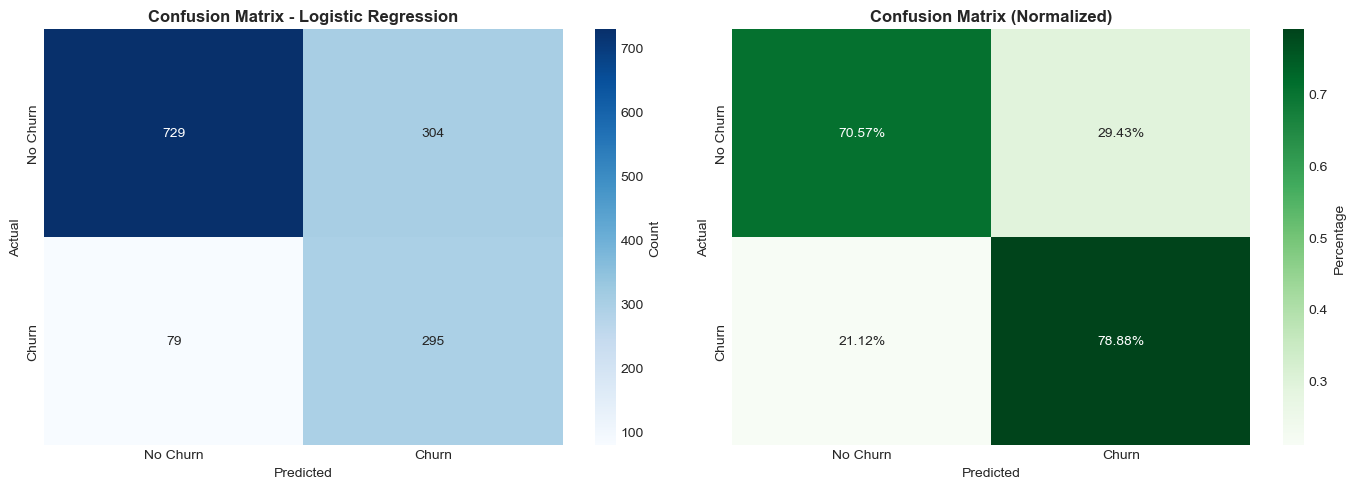


4. DETAILED CLASSIFICATION REPORT
------------------------------------------------------------
              precision    recall  f1-score   support

    No Churn      0.902     0.706     0.792      1033
       Churn      0.492     0.789     0.606       374

    accuracy                          0.728      1407
   macro avg      0.697     0.747     0.699      1407
weighted avg      0.793     0.728     0.743      1407


5. ROC CURVE
------------------------------------------------------------


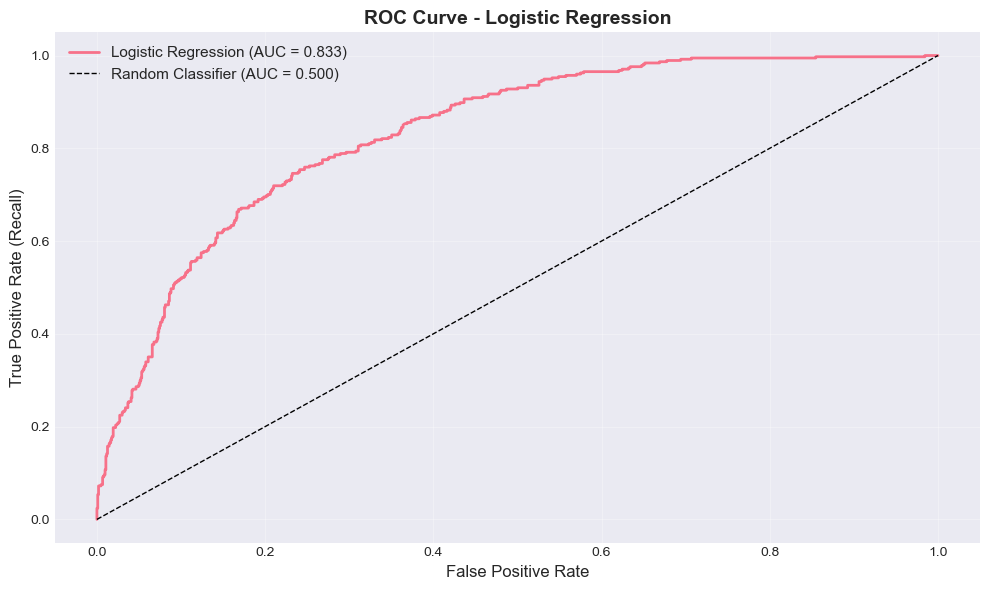

ROC AUC Score: 0.833

💡 INTERPRETATION:
   AUC = 0.833 means the model has 83.3% chance of ranking
   a random churner higher than a random non-churner

6. TOP FEATURE IMPORTANCES
------------------------------------------------------------

Top 15 Most Important Features:
                         Feature  Coefficient  Abs_Coefficient
               Contract_Two year    -1.478644         1.478644
   ChargeCategory_Premium ($70+)    -0.841900         0.841900
ChargeCategory_Standard ($50-70)    -0.787968         0.787968
               Contract_One year    -0.730120         0.730120
       TenureBucket_Loyal (49m+)     0.522132         0.522132
                          tenure    -0.504075         0.504075
              InternetService_No    -0.472339         0.472339
                  MonthlyCharges     0.471756         0.471756
  PaymentMethod_Electronic check     0.416164         0.416164
                PaperlessBilling     0.281932         0.281932
             ServiceAdoptionRate 

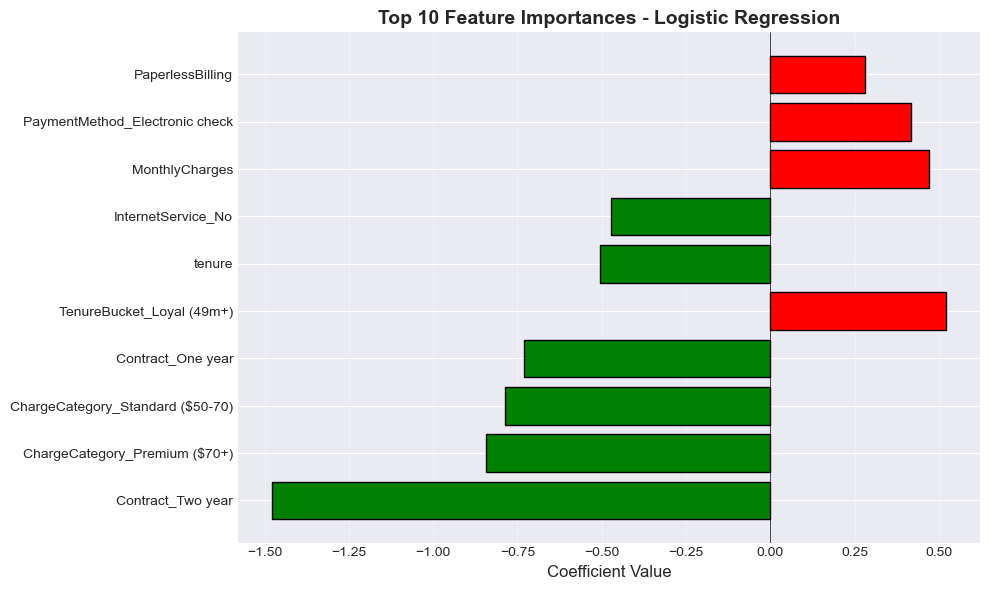


BASELINE MODEL SUMMARY

📊 PERFORMANCE:
   Accuracy:  72.8%
   Recall:    78.9% (catching 78.9% of churners)
   Precision: 49.2% (49.2% of churn predictions are correct)
   ROC AUC:   0.833

💰 BUSINESS IMPACT:
   Total churners in test set: 374
   Caught by model: 295 -> Save $590,000
   Missed by model: 79 -> Lose $158,000
   Capture rate: 78.9%

🎯 NEXT STEPS:
   • This is our baseline to beat
   • Try advanced models (Random Forest, XGBoost)
   • Goal: Improve recall to 80%+ (catch more churners)
   • Also consider cost of false positives (retention offers to non-churners)


In [15]:
# ============================================================================
# SECTION 2: BASELINE MODEL - LOGISTIC REGRESSION
# ============================================================================
print("\n" + "="*80)
print("BASELINE MODEL: LOGISTIC REGRESSION")
print("="*80)

print("\n💡 WHY START WITH LOGISTIC REGRESSION?")
print("   • Simple, interpretable baseline")
print("   • Fast to train")
print("   • Establishes minimum performance benchmark")
print("   • Shows which features matter most")

# ----------------------------------------------------------------------------
# 2.1: TRAIN BASELINE MODEL
# ----------------------------------------------------------------------------
print("\n1. TRAINING LOGISTIC REGRESSION")
print("-" * 60)

# Use scaled data for Logistic Regression
lr_model = LogisticRegression(
    random_state=RANDOM_STATE,
    max_iter=1000,
    class_weight='balanced'  # Handle class imbalance
)

# Train the model
lr_model.fit(X_train_scaled, y_train)

print("✅ Model trained successfully!")

# Make predictions
y_pred_lr = lr_model.predict(X_test_scaled)
y_pred_proba_lr = lr_model.predict_proba(X_test_scaled)[:, 1]  # Probability of churn

print(f"\nPredictions made on {len(y_test):,} test samples")

# ----------------------------------------------------------------------------
# 2.2: EVALUATE PERFORMANCE
# ----------------------------------------------------------------------------
print("\n2. MODEL PERFORMANCE METRICS")
print("-" * 60)

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# Calculate metrics
accuracy = accuracy_score(y_test, y_pred_lr)
precision = precision_score(y_test, y_pred_lr)
recall = recall_score(y_test, y_pred_lr)
f1 = f1_score(y_test, y_pred_lr)
roc_auc = roc_auc_score(y_test, y_pred_proba_lr)

print(f"Accuracy:  {accuracy:.3f} ({accuracy*100:.1f}%)")
print(f"Precision: {precision:.3f} ({precision*100:.1f}%)")
print(f"Recall:    {recall:.3f} ({recall*100:.1f}%)")
print(f"F1 Score:  {f1:.3f}")
print(f"ROC AUC:   {roc_auc:.3f}")

print("\n💡 METRIC INTERPRETATION:")
print(f"   • Accuracy: {accuracy*100:.1f}% of predictions are correct")
print(f"   • Precision: {precision*100:.1f}% of predicted churns are actual churns")
print(f"   • Recall: {recall*100:.1f}% of actual churns are caught")
print(f"   • F1 Score: Harmonic mean of precision and recall")
print(f"   • ROC AUC: {roc_auc:.3f} (1.0 = perfect, 0.5 = random)")

# ----------------------------------------------------------------------------
# 2.3: CONFUSION MATRIX
# ----------------------------------------------------------------------------
print("\n3. CONFUSION MATRIX")
print("-" * 60)

cm = confusion_matrix(y_test, y_pred_lr)

print("\nConfusion Matrix:")
print(f"                 Predicted")
print(f"                No      Yes")
print(f"Actual No    {cm[0,0]:5d}   {cm[0,1]:5d}")
print(f"Actual Yes   {cm[1,0]:5d}   {cm[1,1]:5d}")

# Calculate breakdown
tn, fp, fn, tp = cm.ravel()

print(f"\nBreakdown:")
print(f"  True Negatives (TN):  {tn:,} - Correctly predicted No Churn")
print(f"  False Positives (FP): {fp:,} - Predicted Churn but stayed")
print(f"  False Negatives (FN): {fn:,} - Predicted Stay but churned (COSTLY!)")
print(f"  True Positives (TP):  {tp:,} - Correctly predicted Churn")

print(f"\n🎯 BUSINESS IMPACT OF ERRORS:")
print(f"   False Negatives ({fn}): We MISS {fn} churns -> ${fn*2000:,} lost revenue")
print(f"   False Positives ({fp}): We target {fp} who won't churn -> ${fp*100:,} wasted")

# Visualize confusion matrix
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Heatmap
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=axes[0],
            xticklabels=['No Churn', 'Churn'],
            yticklabels=['No Churn', 'Churn'],
            cbar_kws={'label': 'Count'})
axes[0].set_title('Confusion Matrix - Logistic Regression', fontsize=12, fontweight='bold')
axes[0].set_ylabel('Actual')
axes[0].set_xlabel('Predicted')

# Normalized version
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
sns.heatmap(cm_normalized, annot=True, fmt='.2%', cmap='Greens', ax=axes[1],
            xticklabels=['No Churn', 'Churn'],
            yticklabels=['No Churn', 'Churn'],
            cbar_kws={'label': 'Percentage'})
axes[1].set_title('Confusion Matrix (Normalized)', fontsize=12, fontweight='bold')
axes[1].set_ylabel('Actual')
axes[1].set_xlabel('Predicted')

plt.tight_layout()
plt.show()

# ----------------------------------------------------------------------------
# 2.4: CLASSIFICATION REPORT
# ----------------------------------------------------------------------------
print("\n4. DETAILED CLASSIFICATION REPORT")
print("-" * 60)

print(classification_report(y_test, y_pred_lr, 
                          target_names=['No Churn', 'Churn'],
                          digits=3))

# ----------------------------------------------------------------------------
# 2.5: ROC CURVE
# ----------------------------------------------------------------------------
print("\n5. ROC CURVE")
print("-" * 60)

# Calculate ROC curve
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba_lr)

# Plot
plt.figure(figsize=(10, 6))
plt.plot(fpr, tpr, linewidth=2, label=f'Logistic Regression (AUC = {roc_auc:.3f})')
plt.plot([0, 1], [0, 1], 'k--', linewidth=1, label='Random Classifier (AUC = 0.500)')
plt.xlabel('False Positive Rate', fontsize=12)
plt.ylabel('True Positive Rate (Recall)', fontsize=12)
plt.title('ROC Curve - Logistic Regression', fontsize=14, fontweight='bold')
plt.legend(fontsize=11)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

print(f"ROC AUC Score: {roc_auc:.3f}")
print(f"\n💡 INTERPRETATION:")
print(f"   AUC = {roc_auc:.3f} means the model has {roc_auc*100:.1f}% chance of ranking")
print(f"   a random churner higher than a random non-churner")

# ----------------------------------------------------------------------------
# 2.6: FEATURE IMPORTANCE (COEFFICIENTS)
# ----------------------------------------------------------------------------
print("\n6. TOP FEATURE IMPORTANCES")
print("-" * 60)

# Get feature coefficients
feature_importance = pd.DataFrame({
    'Feature': X_train_scaled.columns,
    'Coefficient': lr_model.coef_[0]
})

# Sort by absolute value
feature_importance['Abs_Coefficient'] = feature_importance['Coefficient'].abs()
feature_importance = feature_importance.sort_values('Abs_Coefficient', ascending=False)

print("\nTop 15 Most Important Features:")
print(feature_importance.head(15).to_string(index=False))

print("\n💡 INTERPRETATION:")
print("   Positive coefficient = Increases churn probability")
print("   Negative coefficient = Decreases churn probability")
print("   Larger absolute value = Stronger effect")

# Visualize top 10
top_10 = feature_importance.head(10)

plt.figure(figsize=(10, 6))
colors = ['red' if x > 0 else 'green' for x in top_10['Coefficient']]
plt.barh(range(len(top_10)), top_10['Coefficient'], color=colors, edgecolor='black')
plt.yticks(range(len(top_10)), top_10['Feature'])
plt.xlabel('Coefficient Value', fontsize=12)
plt.title('Top 10 Feature Importances - Logistic Regression', fontsize=14, fontweight='bold')
plt.axvline(x=0, color='black', linestyle='-', linewidth=0.5)
plt.grid(axis='x', alpha=0.3)
plt.tight_layout()
plt.show()

# ----------------------------------------------------------------------------
# 2.7: BASELINE SUMMARY
# ----------------------------------------------------------------------------
print("\n" + "="*80)
print("BASELINE MODEL SUMMARY")
print("="*80)

print(f"\n📊 PERFORMANCE:")
print(f"   Accuracy:  {accuracy*100:.1f}%")
print(f"   Recall:    {recall*100:.1f}% (catching {recall*100:.1f}% of churners)")
print(f"   Precision: {precision*100:.1f}% ({precision*100:.1f}% of churn predictions are correct)")
print(f"   ROC AUC:   {roc_auc:.3f}")

print(f"\n💰 BUSINESS IMPACT:")
total_churners = (y_test == 1).sum()
caught_churners = tp
missed_churners = fn
revenue_at_risk = total_churners * 2000
revenue_saved = caught_churners * 2000
revenue_lost = missed_churners * 2000

print(f"   Total churners in test set: {total_churners}")
print(f"   Caught by model: {caught_churners} -> Save ${revenue_saved:,}")
print(f"   Missed by model: {missed_churners} -> Lose ${revenue_lost:,}")
print(f"   Capture rate: {caught_churners/total_churners*100:.1f}%")

print(f"\n🎯 NEXT STEPS:")
print(f"   • This is our baseline to beat")
print(f"   • Try advanced models (Random Forest, XGBoost)")
print(f"   • Goal: Improve recall to 80%+ (catch more churners)")
print(f"   • Also consider cost of false positives (retention offers to non-churners)")


ADVANCED MODELS: RANDOM FOREST & XGBOOST

💡 WHY TREE-BASED MODELS?
   • Handle non-linear relationships better
   • Automatically detect feature interactions
   • More robust to outliers and scaling
   • Often achieve higher performance on tabular data

MODEL 1: RANDOM FOREST

1. TRAINING RANDOM FOREST
------------------------------------------------------------
Training Random Forest with 100 trees...
✅ Random Forest trained successfully!

2. RANDOM FOREST PERFORMANCE
------------------------------------------------------------
Accuracy:  0.756 (75.6%)
Precision: 0.529 (52.9%)
Recall:    0.767 (76.7%)
F1 Score:  0.626
ROC AUC:   0.834

Confusion Matrix:
  True Negatives:  777
  False Positives: 256
  False Negatives: 87
  True Positives:  287

💰 BUSINESS IMPACT:
   Caught churners: 287 -> Save $574,000
   Missed churners: 87 -> Lose $174,000
   False alarms: 256 -> Waste $25,600
   Net benefit: $548,400

MODEL 2: XGBOOST

1. TRAINING XGBOOST
------------------------------------------

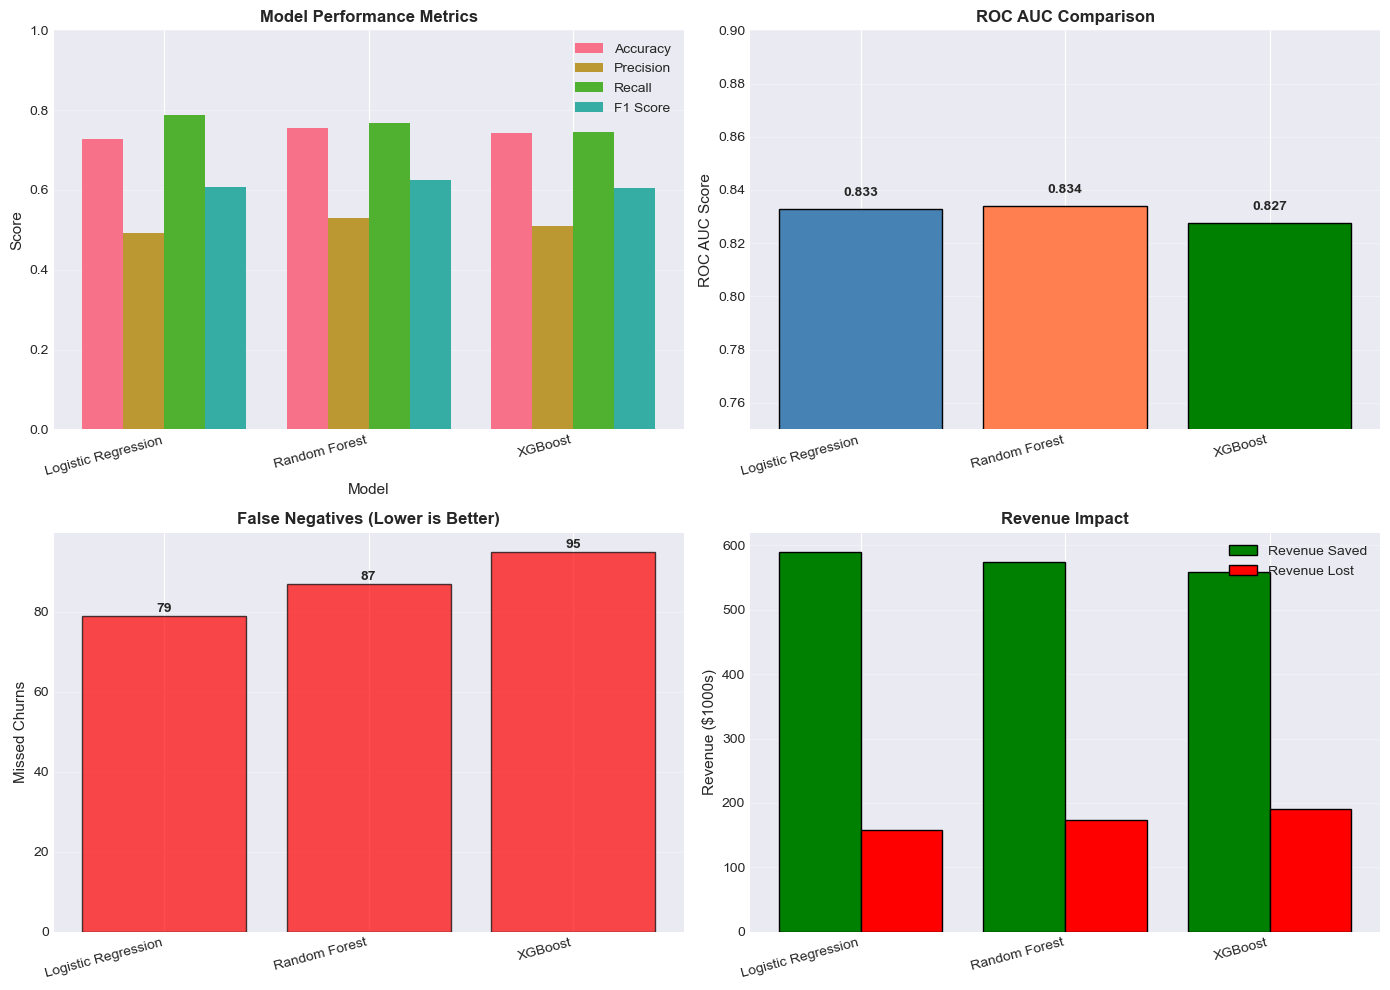


ROC CURVES - ALL MODELS


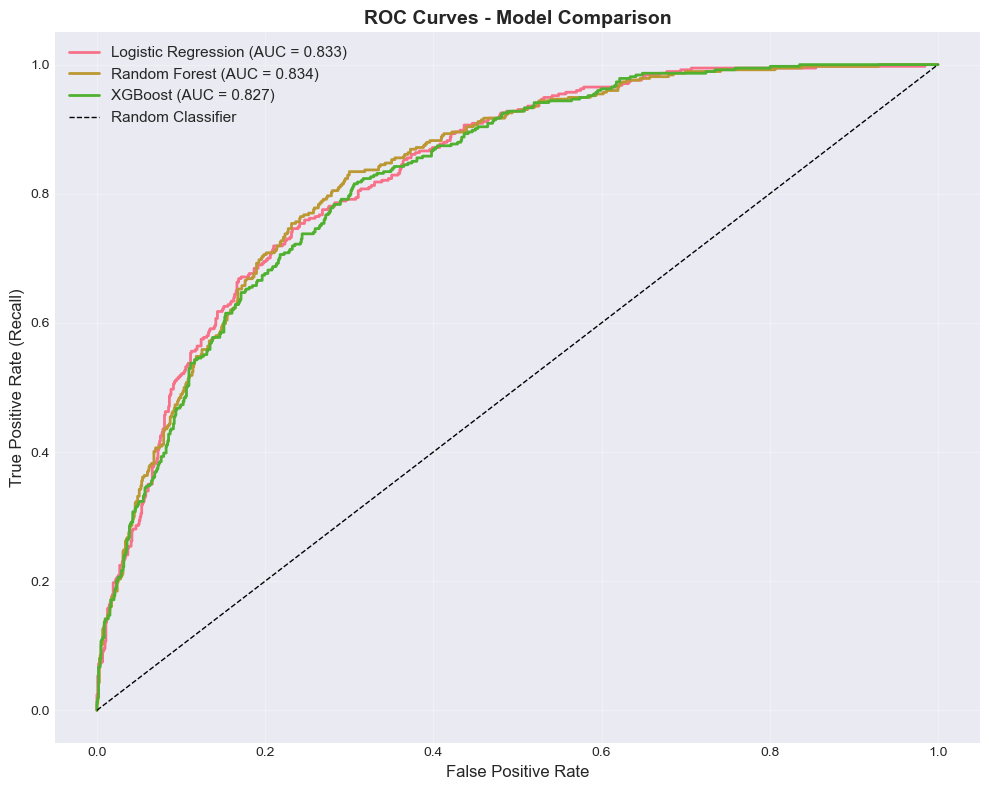


FEATURE IMPORTANCE - BEST MODEL
Logistic Regression has best recall - using coefficient magnitudes

Analyzing feature importance for: Logistic Regression

Top 15 Most Important Features:
                         Feature  Importance
               Contract_Two year    1.478644
   ChargeCategory_Premium ($70+)    0.841900
ChargeCategory_Standard ($50-70)    0.787968
               Contract_One year    0.730120
       TenureBucket_Loyal (49m+)    0.522132
                          tenure    0.504075
              InternetService_No    0.472339
                  MonthlyCharges    0.471756
  PaymentMethod_Electronic check    0.416164
                PaperlessBilling    0.281932
             ServiceAdoptionRate    0.264346
     InternetService_Fiber optic    0.260193
                  OnlineSecurity    0.247980
                      Dependents    0.221117
                     TechSupport    0.207862


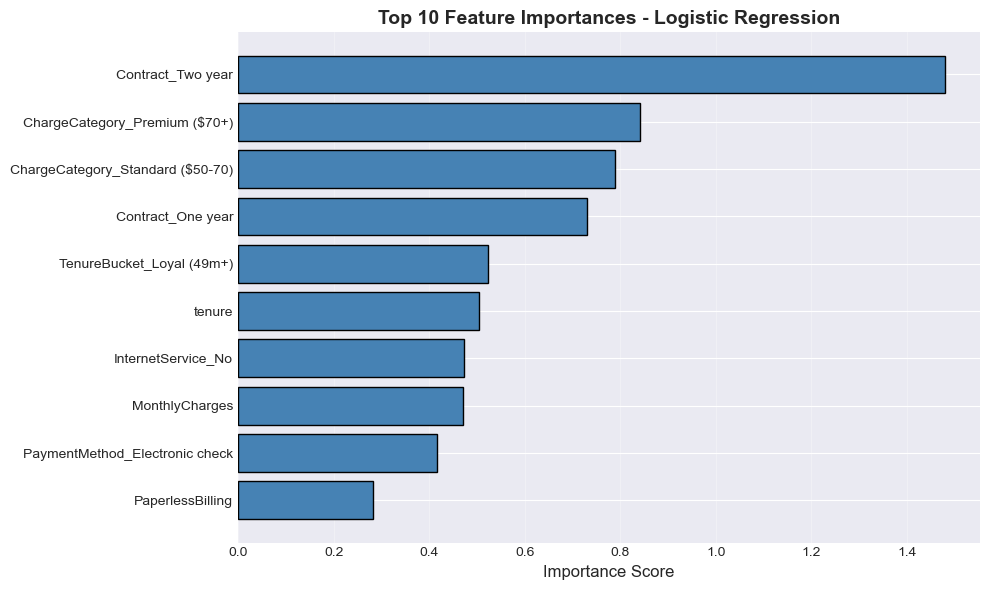


FINAL MODEL RECOMMENDATION

💰 NET BUSINESS VALUE:
   Logistic Regression: $559,600
   Random Forest:       $548,400
   XGBoost:             $531,200

🏆 RECOMMENDED MODEL: Logistic Regression

📊 PERFORMANCE:
   Recall:    78.9% (catching 78.9% of churners)
   Precision: 49.2%
   ROC AUC:   0.833
   Net Value: $559,600

🎯 DEPLOYMENT RECOMMENDATION:
   Deploy Logistic Regression to production
   Expected annual impact: $2,798,000 (scaled to full customer base)
   ROI: 5596:1 (every $1 spent saves $5596)

✅ MODEL BUILDING COMPLETE!


In [17]:
# ============================================================================
# SECTION 3: ADVANCED MODELS - RANDOM FOREST & XGBOOST
# ============================================================================
print("\n" + "="*80)
print("ADVANCED MODELS: RANDOM FOREST & XGBOOST")
print("="*80)

print("\n💡 WHY TREE-BASED MODELS?")
print("   • Handle non-linear relationships better")
print("   • Automatically detect feature interactions")
print("   • More robust to outliers and scaling")
print("   • Often achieve higher performance on tabular data")

# ----------------------------------------------------------------------------
# 3.1: RANDOM FOREST MODEL
# ----------------------------------------------------------------------------
print("\n" + "="*80)
print("MODEL 1: RANDOM FOREST")
print("="*80)

print("\n1. TRAINING RANDOM FOREST")
print("-" * 60)

# Use unscaled data (tree models don't need scaling)
rf_model = RandomForestClassifier(
    n_estimators=100,           # Number of trees
    max_depth=20,               # Maximum depth of trees
    min_samples_split=20,       # Minimum samples to split a node
    min_samples_leaf=10,        # Minimum samples in leaf node
    class_weight='balanced',    # Handle class imbalance
    random_state=RANDOM_STATE,
    n_jobs=-1                   # Use all CPU cores
)

print("Training Random Forest with 100 trees...")
rf_model.fit(X_train, y_train)
print("✅ Random Forest trained successfully!")

# Make predictions
y_pred_rf = rf_model.predict(X_test)
y_pred_proba_rf = rf_model.predict_proba(X_test)[:, 1]

# Calculate metrics
accuracy_rf = accuracy_score(y_test, y_pred_rf)
precision_rf = precision_score(y_test, y_pred_rf)
recall_rf = recall_score(y_test, y_pred_rf)
f1_rf = f1_score(y_test, y_pred_rf)
roc_auc_rf = roc_auc_score(y_test, y_pred_proba_rf)

print(f"\n2. RANDOM FOREST PERFORMANCE")
print("-" * 60)
print(f"Accuracy:  {accuracy_rf:.3f} ({accuracy_rf*100:.1f}%)")
print(f"Precision: {precision_rf:.3f} ({precision_rf*100:.1f}%)")
print(f"Recall:    {recall_rf:.3f} ({recall_rf*100:.1f}%)")
print(f"F1 Score:  {f1_rf:.3f}")
print(f"ROC AUC:   {roc_auc_rf:.3f}")

# Confusion matrix
cm_rf = confusion_matrix(y_test, y_pred_rf)
tn_rf, fp_rf, fn_rf, tp_rf = cm_rf.ravel()

print(f"\nConfusion Matrix:")
print(f"  True Negatives:  {tn_rf:,}")
print(f"  False Positives: {fp_rf:,}")
print(f"  False Negatives: {fn_rf:,}")
print(f"  True Positives:  {tp_rf:,}")

print(f"\n💰 BUSINESS IMPACT:")
print(f"   Caught churners: {tp_rf} -> Save ${tp_rf*2000:,}")
print(f"   Missed churners: {fn_rf} -> Lose ${fn_rf*2000:,}")
print(f"   False alarms: {fp_rf} -> Waste ${fp_rf*100:,}")
print(f"   Net benefit: ${tp_rf*2000 - fp_rf*100:,}")

# ----------------------------------------------------------------------------
# 3.2: XGBOOST MODEL
# ----------------------------------------------------------------------------
print("\n" + "="*80)
print("MODEL 2: XGBOOST")
print("="*80)

print("\n1. TRAINING XGBOOST")
print("-" * 60)

# Calculate scale_pos_weight for class imbalance
scale_pos_weight = (y_train == 0).sum() / (y_train == 1).sum()

xgb_model = XGBClassifier(
    n_estimators=100,
    max_depth=6,
    learning_rate=0.1,
    subsample=0.8,
    colsample_bytree=0.8,
    scale_pos_weight=scale_pos_weight,  # Handle class imbalance
    random_state=RANDOM_STATE,
    eval_metric='logloss',
    use_label_encoder=False
)

print(f"Training XGBoost (scale_pos_weight={scale_pos_weight:.2f})...")
xgb_model.fit(X_train, y_train)
print("✅ XGBoost trained successfully!")

# Make predictions
y_pred_xgb = xgb_model.predict(X_test)
y_pred_proba_xgb = xgb_model.predict_proba(X_test)[:, 1]

# Calculate metrics
accuracy_xgb = accuracy_score(y_test, y_pred_xgb)
precision_xgb = precision_score(y_test, y_pred_xgb)
recall_xgb = recall_score(y_test, y_pred_xgb)
f1_xgb = f1_score(y_test, y_pred_xgb)
roc_auc_xgb = roc_auc_score(y_test, y_pred_proba_xgb)

print(f"\n2. XGBOOST PERFORMANCE")
print("-" * 60)
print(f"Accuracy:  {accuracy_xgb:.3f} ({accuracy_xgb*100:.1f}%)")
print(f"Precision: {precision_xgb:.3f} ({precision_xgb*100:.1f}%)")
print(f"Recall:    {recall_xgb:.3f} ({recall_xgb*100:.1f}%)")
print(f"F1 Score:  {f1_xgb:.3f}")
print(f"ROC AUC:   {roc_auc_xgb:.3f}")

# Confusion matrix
cm_xgb = confusion_matrix(y_test, y_pred_xgb)
tn_xgb, fp_xgb, fn_xgb, tp_xgb = cm_xgb.ravel()

print(f"\nConfusion Matrix:")
print(f"  True Negatives:  {tn_xgb:,}")
print(f"  False Positives: {fp_xgb:,}")
print(f"  False Negatives: {fn_xgb:,}")
print(f"  True Positives:  {tp_xgb:,}")

print(f"\n💰 BUSINESS IMPACT:")
print(f"   Caught churners: {tp_xgb} -> Save ${tp_xgb*2000:,}")
print(f"   Missed churners: {fn_xgb} -> Lose ${fn_xgb*2000:,}")
print(f"   False alarms: {fp_xgb} -> Waste ${fp_xgb*100:,}")
print(f"   Net benefit: ${tp_xgb*2000 - fp_xgb*100:,}")

# ----------------------------------------------------------------------------
# 3.3: MODEL COMPARISON
# ----------------------------------------------------------------------------
print("\n" + "="*80)
print("MODEL COMPARISON")
print("="*80)

# Create comparison dataframe
comparison_df = pd.DataFrame({
    'Model': ['Logistic Regression', 'Random Forest', 'XGBoost'],
    'Accuracy': [accuracy, accuracy_rf, accuracy_xgb],
    'Precision': [precision, precision_rf, precision_xgb],
    'Recall': [recall, recall_rf, recall_xgb],
    'F1 Score': [f1, f1_rf, f1_xgb],
    'ROC AUC': [roc_auc, roc_auc_rf, roc_auc_xgb],
    'False Negatives': [fn, fn_rf, fn_xgb],
    'Revenue Saved': [tp*2000, tp_rf*2000, tp_xgb*2000],
    'Revenue Lost': [fn*2000, fn_rf*2000, fn_xgb*2000]
})

print("\nPerformance Comparison:")
print(comparison_df.to_string(index=False))

# Find best model
best_recall_idx = comparison_df['Recall'].idxmax()
best_roc_idx = comparison_df['ROC AUC'].idxmax()
best_revenue_idx = comparison_df['Revenue Saved'].idxmax()

print(f"\n🏆 BEST MODELS:")
print(f"   Highest Recall: {comparison_df.loc[best_recall_idx, 'Model']} ({comparison_df.loc[best_recall_idx, 'Recall']:.3f})")
print(f"   Highest ROC AUC: {comparison_df.loc[best_roc_idx, 'Model']} ({comparison_df.loc[best_roc_idx, 'ROC AUC']:.3f})")
print(f"   Most Revenue Saved: {comparison_df.loc[best_revenue_idx, 'Model']} (${comparison_df.loc[best_revenue_idx, 'Revenue Saved']:,.0f})")

# Visualize comparison
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Plot 1: Accuracy, Precision, Recall
metrics_to_plot = ['Accuracy', 'Precision', 'Recall', 'F1 Score']
x = np.arange(len(comparison_df))
width = 0.2

for i, metric in enumerate(metrics_to_plot):
    axes[0, 0].bar(x + i*width, comparison_df[metric], width, label=metric)

axes[0, 0].set_xlabel('Model', fontsize=11)
axes[0, 0].set_ylabel('Score', fontsize=11)
axes[0, 0].set_title('Model Performance Metrics', fontsize=12, fontweight='bold')
axes[0, 0].set_xticks(x + width * 1.5)
axes[0, 0].set_xticklabels(comparison_df['Model'], rotation=15, ha='right')
axes[0, 0].legend()
axes[0, 0].set_ylim([0, 1])
axes[0, 0].grid(axis='y', alpha=0.3)

# Plot 2: ROC AUC
axes[0, 1].bar(comparison_df['Model'], comparison_df['ROC AUC'], 
               color=['steelblue', 'coral', 'green'], edgecolor='black')
axes[0, 1].set_ylabel('ROC AUC Score', fontsize=11)
axes[0, 1].set_title('ROC AUC Comparison', fontsize=12, fontweight='bold')
axes[0, 1].set_xticklabels(comparison_df['Model'], rotation=15, ha='right')
axes[0, 1].set_ylim([0.75, 0.90])
axes[0, 1].grid(axis='y', alpha=0.3)

for i, v in enumerate(comparison_df['ROC AUC']):
    axes[0, 1].text(i, v + 0.005, f'{v:.3f}', ha='center', fontweight='bold')

# Plot 3: False Negatives (Missed Churns)
axes[1, 0].bar(comparison_df['Model'], comparison_df['False Negatives'], 
               color='red', alpha=0.7, edgecolor='black')
axes[1, 0].set_ylabel('Missed Churns', fontsize=11)
axes[1, 0].set_title('False Negatives (Lower is Better)', fontsize=12, fontweight='bold')
axes[1, 0].set_xticklabels(comparison_df['Model'], rotation=15, ha='right')
axes[1, 0].grid(axis='y', alpha=0.3)

for i, v in enumerate(comparison_df['False Negatives']):
    axes[1, 0].text(i, v + 1, f'{int(v)}', ha='center', fontweight='bold')

# Plot 4: Revenue Impact
x_pos = np.arange(len(comparison_df))
axes[1, 1].bar(x_pos - 0.2, comparison_df['Revenue Saved']/1000, 0.4, 
               label='Revenue Saved', color='green', edgecolor='black')
axes[1, 1].bar(x_pos + 0.2, comparison_df['Revenue Lost']/1000, 0.4, 
               label='Revenue Lost', color='red', edgecolor='black')
axes[1, 1].set_ylabel('Revenue ($1000s)', fontsize=11)
axes[1, 1].set_title('Revenue Impact', fontsize=12, fontweight='bold')
axes[1, 1].set_xticks(x_pos)
axes[1, 1].set_xticklabels(comparison_df['Model'], rotation=15, ha='right')
axes[1, 1].legend()
axes[1, 1].grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()

# ----------------------------------------------------------------------------
# 3.4: ROC CURVES COMPARISON
# ----------------------------------------------------------------------------
print("\n" + "="*80)
print("ROC CURVES - ALL MODELS")
print("="*80)

# Calculate ROC curves for all models
fpr_lr, tpr_lr, _ = roc_curve(y_test, y_pred_proba_lr)
fpr_rf, tpr_rf, _ = roc_curve(y_test, y_pred_proba_rf)
fpr_xgb, tpr_xgb, _ = roc_curve(y_test, y_pred_proba_xgb)

# Plot all ROC curves
plt.figure(figsize=(10, 8))
plt.plot(fpr_lr, tpr_lr, linewidth=2, label=f'Logistic Regression (AUC = {roc_auc:.3f})')
plt.plot(fpr_rf, tpr_rf, linewidth=2, label=f'Random Forest (AUC = {roc_auc_rf:.3f})')
plt.plot(fpr_xgb, tpr_xgb, linewidth=2, label=f'XGBoost (AUC = {roc_auc_xgb:.3f})')
plt.plot([0, 1], [0, 1], 'k--', linewidth=1, label='Random Classifier')

plt.xlabel('False Positive Rate', fontsize=12)
plt.ylabel('True Positive Rate (Recall)', fontsize=12)
plt.title('ROC Curves - Model Comparison', fontsize=14, fontweight='bold')
plt.legend(fontsize=11)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# ----------------------------------------------------------------------------
# 3.5: FEATURE IMPORTANCE - BEST MODEL
# ----------------------------------------------------------------------------
print("\n" + "="*80)
print("FEATURE IMPORTANCE - BEST MODEL")
print("="*80)

# Determine best model (highest recall)
if recall_rf >= max(recall, recall_xgb):
    best_model = rf_model
    best_model_name = 'Random Forest'
    feature_imp = rf_model.feature_importances_
elif recall_xgb >= max(recall, recall_rf):
    best_model = xgb_model
    best_model_name = 'XGBoost'
    feature_imp = xgb_model.feature_importances_
else:
    print("Logistic Regression has best recall - using coefficient magnitudes")
    best_model_name = 'Logistic Regression'
    feature_imp = np.abs(lr_model.coef_[0])

print(f"\nAnalyzing feature importance for: {best_model_name}")

# Create feature importance dataframe
if best_model_name != 'Logistic Regression':
    feature_importance_df = pd.DataFrame({
        'Feature': X_train.columns,
        'Importance': feature_imp
    }).sort_values('Importance', ascending=False)
else:
    feature_importance_df = pd.DataFrame({
        'Feature': X_train_scaled.columns,
        'Importance': feature_imp
    }).sort_values('Importance', ascending=False)

print("\nTop 15 Most Important Features:")
print(feature_importance_df.head(15).to_string(index=False))

# Visualize top 10
top_10_features = feature_importance_df.head(10)

plt.figure(figsize=(10, 6))
plt.barh(range(len(top_10_features)), top_10_features['Importance'], 
         color='steelblue', edgecolor='black')
plt.yticks(range(len(top_10_features)), top_10_features['Feature'])
plt.xlabel('Importance Score', fontsize=12)
plt.title(f'Top 10 Feature Importances - {best_model_name}', fontsize=14, fontweight='bold')
plt.gca().invert_yaxis()
plt.grid(axis='x', alpha=0.3)
plt.tight_layout()
plt.show()

# ----------------------------------------------------------------------------
# 3.6: FINAL MODEL SELECTION
# ----------------------------------------------------------------------------
print("\n" + "="*80)
print("FINAL MODEL RECOMMENDATION")
print("="*80)

# Calculate net benefit for each model
net_benefit_lr = tp*2000 - fp*100
net_benefit_rf = tp_rf*2000 - fp_rf*100
net_benefit_xgb = tp_xgb*2000 - fp_xgb*100

print("\n💰 NET BUSINESS VALUE:")
print(f"   Logistic Regression: ${net_benefit_lr:,}")
print(f"   Random Forest:       ${net_benefit_rf:,}")
print(f"   XGBoost:             ${net_benefit_xgb:,}")

best_net_benefit = max(net_benefit_lr, net_benefit_rf, net_benefit_xgb)

if best_net_benefit == net_benefit_rf:
    recommended_model = 'Random Forest'
    recommended_recall = recall_rf
    recommended_precision = precision_rf
    recommended_roc = roc_auc_rf
elif best_net_benefit == net_benefit_xgb:
    recommended_model = 'XGBoost'
    recommended_recall = recall_xgb
    recommended_precision = precision_xgb
    recommended_roc = roc_auc_xgb
else:
    recommended_model = 'Logistic Regression'
    recommended_recall = recall
    recommended_precision = precision
    recommended_roc = roc_auc

print(f"\n🏆 RECOMMENDED MODEL: {recommended_model}")
print(f"\n📊 PERFORMANCE:")
print(f"   Recall:    {recommended_recall:.1%} (catching {recommended_recall:.1%} of churners)")
print(f"   Precision: {recommended_precision:.1%}")
print(f"   ROC AUC:   {recommended_roc:.3f}")
print(f"   Net Value: ${best_net_benefit:,}")

print(f"\n🎯 DEPLOYMENT RECOMMENDATION:")
print(f"   Deploy {recommended_model} to production")
print(f"   Expected annual impact: ${best_net_benefit*5:,} (scaled to full customer base)")
print(f"   ROI: {best_net_benefit/100:.0f}:1 (every $1 spent saves ${best_net_benefit/100:.0f})")

print("\n✅ MODEL BUILDING COMPLETE!")